In [1]:
import time
import random
import math
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
import tiktoken

print('All imports done.')

/Users/gprajeshkumar/Documents/NYU Courant/Machine Learning/hws/pico-llm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gprajeshkumar/Documents/NYU Courant/Machine Learning/hws/pico-llm/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


All imports done.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: mps


### Hyperparameters

For Data
1. block_size
2. train_subset_size
3. batch_size
4. tinystories_weights


In [3]:
# Data parameters
block_size = 128  # Sequence length for training
train_subset_size = 30000  # Number of samples to use from TinyStories
batch_size = 16

tinystories_weight = 0.5  # Proportion of TinyStories in mixed dataset (0.0 to skip)

# Training parameters
epochs = 2
learning_rate = 5e-3
log_steps = 100
sample_interval = 30  # seconds between text samples during training
max_steps_per_epoch = None  # Set to an int for quick tests

transformer_d_model = 512
transformer_n_heads = 8
transformer_n_blocks = 4
transformer_max_seq_len = block_size


# Prompt for text generation
default_prompt = "Once upon a time"

In [4]:
# Load tokenizer
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab

# Load TinyStories dataset
tinystories_seqs = []
if tinystories_weight > 0.0:
    print(f"Loading TinyStories from huggingface with weight={tinystories_weight}...")
    dataset = load_dataset("roneneldan/TinyStories", split="train")
    train_dataset = dataset.select(range(train_subset_size))
    for sample in train_dataset:
        text = sample['text']
        tokens = enc.encode(text)
        tokens = tokens[:block_size]
        if len(tokens) > 0:
            tinystories_seqs.append(tokens)
    print(f"TinyStories sequences: {len(tinystories_seqs)}")
else:
    print("TinyStories weight=0 => skipping TinyStories.")
other_seqs = []

Loading TinyStories from huggingface with weight=0.5...
TinyStories sequences: 30000


In [5]:
class MixedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, tinystories_seqs, other_seqs, p_tiny: float):
        super().__init__()
        self.tinystories_seqs = tinystories_seqs
        self.other_seqs = other_seqs
        self.p_tiny = p_tiny
        self.has_tinystories = (len(self.tinystories_seqs) > 0)
        self.has_other = (len(self.other_seqs) > 0)
        self.total_length = len(self.tinystories_seqs) + len(self.other_seqs)
        if self.total_length == 0:
            raise ValueError("No data found! Both TinyStories and other sets are empty.")

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        import random
        r = random.random()
        if self.has_tinystories and self.has_other:
            if r < self.p_tiny:
                i = random.randint(0, len(self.tinystories_seqs) - 1)
                seq = self.tinystories_seqs[i]
            else:
                i = random.randint(0, len(self.other_seqs) - 1)
                seq = self.other_seqs[i]
        elif self.has_tinystories:
            i = random.randint(0, len(self.tinystories_seqs) - 1)
            seq = self.tinystories_seqs[i]
        else:
            i = random.randint(0, len(self.other_seqs) - 1)
            seq = self.other_seqs[i]
        return torch.tensor(seq, dtype=torch.long)

In [6]:
def seq_collate_fn(batch):
    max_len = max(len(seq) for seq in batch)
    batch_size = len(batch)
    padded = torch.zeros(max_len, batch_size, dtype=torch.long)
    for i, seq in enumerate(batch):
        seq_len = seq.size(0)
        padded[:seq_len, i] = seq
    return padded

In [7]:
# Create dataset and loader
p_tiny = tinystories_weight
combined_dataset = MixedSequenceDataset(
    tinystories_seqs=tinystories_seqs,
    other_seqs=other_seqs,
    p_tiny=p_tiny
)

In [8]:
combined_dataset.total_length

30000

In [9]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=seq_collate_fn
)

print("DataLoader ready. Vocab size:", vocab_size)

DataLoader ready. Vocab size: 50257


In [10]:
### Validation 
# Validation data (next 2000 samples)
val_subset_size = train_subset_size // 10  # 2000
tinystories_val_seqs = []
print(f"Loading TinyStories val subset ({train_subset_size}:{train_subset_size + val_subset_size})...")
dataset_val = dataset.select(range(train_subset_size, train_subset_size + val_subset_size))  # 20000..21999
for sample in dataset_val:
    text = sample["text"]
    tokens = enc.encode(text)
    tokens = tokens[:block_size]
    if len(tokens) > 0:
        tinystories_val_seqs.append(tokens)
print(f"TinyStories VAL sequences: {len(tinystories_val_seqs)}")

# Create validation dataset and DataLoader

val_p_tiny = tinystories_weight  # same mixing proportion as training

val_dataset = MixedSequenceDataset(
    tinystories_seqs=tinystories_val_seqs,
    other_seqs=[],          # no other validation data for now
    p_tiny=val_p_tiny
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=seq_collate_fn
)

print("Validation DataLoader ready. Num val sequences:", len(val_dataset))

Loading TinyStories val subset (30000:33000)...
TinyStories VAL sequences: 3000
Validation DataLoader ready. Num val sequences: 3000


In [11]:
def compute_next_token_loss(logits, tokens_seq):
    '''
    logits: (seq_len, batch, vocab_size)
    tokens_seq: (seq_len, batch)
    Computes cross-entropy loss for next-token prediction.
    '''
    seq_len, batch = tokens_seq.shape
    # Predict next token: input t => predict t+1
    logits = logits[:-1]  # (seq_len-1, batch, vocab_size)
    targets = tokens_seq[1:]  # (seq_len-1, batch)
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
    return loss

In [12]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization."""
    def __init__(self, dim: int, eps: float = 1e-6, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.use_bias = bias
        self.bias = nn.Parameter(torch.zeros(dim)) if bias else None
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        y = (x / rms) * self.weight
        if self.use_bias:
            y = y + self.bias
        return y

In [13]:
class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention with optional KV cache."""
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)

    def _split_heads(self, t: torch.Tensor, T: int, B: int) -> torch.Tensor:
        return t.view(T, B, self.n_heads, self.head_dim).permute(1, 2, 0, 3)  # (B,H,T,D)

    def forward(self, x: torch.Tensor, past_kv=None):
        T, B, C = x.shape
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = self._split_heads(q, T, B)
        k = self._split_heads(k, T, B)
        v = self._split_heads(v, T, B)

        if past_kv is not None:
            k_cache, v_cache = past_kv
            if k_cache is not None:
                k = torch.cat([k_cache, k], dim=2)
                v = torch.cat([v_cache, v], dim=2)

        scale = 1.0 / math.sqrt(self.head_dim)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B,H,T,T_total)
        if past_kv is None and T > 1:
            causal_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
            attn_scores = attn_scores.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        attn_probs = torch.softmax(attn_scores, dim=-1)
        ctx = torch.matmul(attn_probs, v)  # (B,H,T,D)
        ctx = ctx.permute(2, 0, 1, 3).contiguous().view(T, B, C)
        out = self.o_proj(ctx)

        if past_kv is not None:
            return out, (k, v)
        else:
            return out


In [14]:
class TransformerBlock(nn.Module):
    
    def __init__(self, d_model: int, n_heads: int, mlp_ratio: float = 4.0):
        super().__init__()
        self.attn_norm = RMSNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads)
        self.mlp_norm = RMSNorm(d_model)
        inner = int(mlp_ratio * d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, inner, bias=False),
            nn.SiLU(),
            nn.Linear(inner, d_model, bias=False),
        )

    def forward(self, x: torch.Tensor, past_kv=None):
        if past_kv is None:
            x = x + self.attn(self.attn_norm(x))
        else:
            attn_out, new_kv = self.attn(self.attn_norm(x), past_kv=past_kv)
            x = x + attn_out
        x = x + self.mlp(self.mlp_norm(x))
        if past_kv is not None:
            return x, new_kv
        return x


In [15]:
class TransformerBlockPostNorm(nn.Module):
    def __init__(self, d_model: int, n_heads: int, mlp_ratio: float = 4.0):
        super().__init__()
        self.attn = CausalSelfAttention(d_model, n_heads)
        self.attn_norm = RMSNorm(d_model)
        inner = int(mlp_ratio * d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, inner, bias=False),
            nn.SiLU(),
            nn.Linear(inner, d_model, bias=False),
        )
        self.mlp_norm = RMSNorm(d_model)

    def forward(self, x: torch.Tensor, past_kv=None):
        # Attention + residual, then norm
        if past_kv is None:
            attn_out = self.attn(x)
        else:
            attn_out, new_kv = self.attn(x, past_kv=past_kv)
        x = x + attn_out
        x = self.attn_norm(x)

        # MLP + residual, then norm
        mlp_out = self.mlp(x)
        x = x + mlp_out
        x = self.mlp_norm(x)

        if past_kv is not None:
            return x, new_kv
        return x

## ⚠️ Architecture Note: Post-Norm Final Normalization

**Current setup** has a potential redundancy:
- Each post-norm block ends with normalization
- The model applies `final_norm` before the output head
- This means the last block's output gets normalized **twice**

**Two options for fair comparison:**

1. **Keep both norms** (current): Both architectures have the same total number of norms, but post-norm has back-to-back norms at the end
2. **Remove `final_norm` from post-norm model**: More faithful to original post-norm design, but pre-norm keeps its `final_norm`

For now, we're keeping both to maintain equal parameter counts and normalization layers. The key difference being tested is **within-block** norm placement.

In [16]:
class TransformerModel(nn.Module):
    """Decoder-only causal Transformer producing logits for next-token prediction."""
    def __init__(self,
                 vocab_size: int = 50257,
                 d_model: int = 512,
                 n_heads: int = 8,
                 n_blocks: int = 6,
                 max_seq_len: int = 2048,
                 mlp_ratio: float = 4.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, mlp_ratio) for _ in range(n_blocks)
        ])
        self.final_norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.token_embed.weight  # Weight tying

    def forward(self, tokens_seq: torch.Tensor, kv_cache=None):
        T, B = tokens_seq.shape
        if T > self.max_seq_len:
            tokens_seq = tokens_seq[-self.max_seq_len:]
            T = tokens_seq.shape[0]
        if kv_cache is not None and len(kv_cache) > 0 and kv_cache[0][0] is not None:
            cached_len = kv_cache[0][0].size(2)
        else:
            cached_len = 0
        pos = torch.arange(cached_len, cached_len + T, device=tokens_seq.device)
        x = self.token_embed(tokens_seq) + self.pos_embed(pos).unsqueeze(1)
        new_cache = [] if kv_cache is not None else None
        if kv_cache is None:
            for blk in self.blocks:
                x = blk(x)
        else:
            for blk, past in zip(self.blocks, kv_cache):
                x, updated = blk(x, past_kv=past)
                new_cache.append(updated)
        x = self.final_norm(x)
        logits = self.lm_head(x)
        if kv_cache is not None:
            return logits, new_cache
        return logits

In [17]:
class TransformerModelPostNorm(nn.Module):
    """Decoder-only causal Transformer using post-norm blocks."""
    def __init__(
        self,
        vocab_size: int = 50257,
        d_model: int = 512,
        n_heads: int = 8,
        n_blocks: int = 6,
        max_seq_len: int = 2048,
        mlp_ratio: float = 4.0,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_seq_len, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlockPostNorm(d_model, n_heads, mlp_ratio) for _ in range(n_blocks)
        ])
        # Post-norm: No final_norm needed since blocks already normalize their outputs
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.token_embed.weight  # weight tying

    def forward(self, tokens_seq: torch.Tensor, kv_cache=None):
        T, B = tokens_seq.shape
        if T > self.max_seq_len:
            tokens_seq = tokens_seq[-self.max_seq_len:]
            T = tokens_seq.shape[0]
        if kv_cache is not None and len(kv_cache) > 0 and kv_cache[0][0] is not None:
            cached_len = kv_cache[0][0].size(2)
        else:
            cached_len = 0
        pos = torch.arange(cached_len, cached_len + T, device=tokens_seq.device)
        x = self.token_embed(tokens_seq) + self.pos_embed(pos).unsqueeze(1)
        new_cache = [] if kv_cache is not None else None
        if kv_cache is None:
            for blk in self.blocks:
                x = blk(x)
        else:
            for blk, past in zip(self.blocks, kv_cache):
                x, updated = blk(x, past_kv=past)
                new_cache.append(updated)
        # No final_norm: post-norm blocks already normalize
        logits = self.lm_head(x)
        if kv_cache is not None:
            return logits, new_cache
        return logits

In [18]:
def nucleus_sampling(logits, p=0.95):
    # Convert logits to probabilities
    prob_dist = torch.softmax(logits, dim=-1)

    # Sort probabilities in descending order and get indices
    sorted_probs, sorted_indices = torch.sort(prob_dist, descending=True)

    # Compute cumulative sum
    cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

    # Find the cutoff index where cumulative probability exceeds p
    # We want to include all tokens up to where cumsum first exceeds p
    cutoff_mask = cumsum_probs <= p

    # Always include at least the first token (highest probability)
    # This handles edge case where first token alone has prob > p
    cutoff_mask[0] = True

    # Zero out probabilities beyond the nucleus
    filtered_probs = sorted_probs.clone()
    filtered_probs[~cutoff_mask] = 0.0

    # Renormalize the remaining probabilities
    filtered_probs = filtered_probs / filtered_probs.sum()

    # Sample from the filtered distribution
    sampled_index = torch.multinomial(filtered_probs, num_samples=1).item()

    # Map back to original token index
    chosen_token = sorted_indices[sampled_index].item()

    return chosen_token


In [19]:
def generate_text(model, enc, init_text, max_new_tokens=20, device="cpu",
                  top_p=None,
                  monosemantic_info=None,
                  do_monosemantic=False,
                  use_kv_cache=False):
    """
    A single code path for all models:
      - We keep a growing list 'context_tokens'.
      - At each step, we feed the entire context as (seq_len,1) to model(...).
      - We get model(...)->(seq_len,1,vocab_size). We take the final step's logits => logits[-1,0,:].
      - We pick next token (greedy or top-p), append to context_tokens.
      - Optionally do monosemantic analysis on that newly generated token.
    """
    was_training = model.training
    model.eval()
    with torch.no_grad():
        context_tokens = enc.encode(init_text)
        annotation_list = []

        kv_cache = None
        # Prime KV cache step-by-step over the initial prompt for strict causality
        if use_kv_cache and hasattr(model, 'blocks') and len(context_tokens) > 0:
            kv_cache = [(None, None) for _ in range(len(model.blocks))]
            for tid in context_tokens:
                tok = torch.tensor([tid], dtype=torch.long, device=device).unsqueeze(1)  # (1,1)
                _, kv_cache = model(tok, kv_cache=kv_cache)

        for step_i in range(max_new_tokens):
            if use_kv_cache and hasattr(model, 'blocks'):
                # Use only the last token and advance cache
                if len(context_tokens) == 0:
                    # Fallback: no context, create a space token as a starter
                    last_id = enc.encode(" ")[-1]
                else:
                    last_id = context_tokens[-1]
                last_token = torch.tensor([last_id], dtype=torch.long, device=device).unsqueeze(1)  # (1,1)
                logits_seq, kv_cache = model(last_token, kv_cache=kv_cache if kv_cache is not None else [(None, None) for _ in range(len(model.blocks))])
                next_logits = logits_seq[-1, 0, :]
            else:
                # Fallback: full context each step (works for all models)
                seq_tensor = torch.tensor(context_tokens, dtype=torch.long, device=device).unsqueeze(1)
                logits_seq = model(seq_tensor)              # (seq_len,1,vocab_size)
                next_logits = logits_seq[-1, 0, :]         # shape (vocab_size,)

            if top_p is None:
                # greedy
                chosen_token = torch.argmax(next_logits).item()
            else:
                chosen_token = nucleus_sampling(next_logits, p=top_p)

            context_tokens.append(chosen_token)

            if do_monosemantic and monosemantic_info is not None:
                neighbors = monosemantic_analysis_for_token(
                    chosen_token, model, monosemantic_info, enc, device=device, top_n=5
                )
                annotation_list.append((chosen_token, neighbors))
            else:
                annotation_list.append((chosen_token, []))

    model.train(was_training)

    final_text = enc.decode(context_tokens)
    prefix_text = enc.decode(context_tokens[:-max_new_tokens])
    annotated_strs = [prefix_text]
    for (tid, neighs) in annotation_list:
        token_str = enc.decode([tid])
        if neighs:
            neighbor_strs = [f"{enc.decode([x[1]])}" for x in neighs]
            annotated = f"{token_str}[NN={neighbor_strs}]"
        else:
            annotated = token_str
        annotated_strs.append(annotated)

    annotated_text = "".join(annotated_strs)
    return final_text, annotated_text


In [20]:
def train_one_model(model,
                    loader,
                    epochs,
                    model_name,
                    device,
                    lr=1e-3,
                    log_steps=100,
                    sample_interval=30,
                    max_steps_per_epoch=None,
                    enc=None,
                    monosemantic_info=None,
                    prompt="Once upon a",
                    log_csv_path: str = "",
                    log_flush_steps: int = 100,
                    val_loader=None,
                    val_log_csv_path: str = "",
                    val_interval_steps: int = None):
    """
    Train the model and optionally run/record validation aligned to training global_step.

    If val_loader and val_log_csv_path are provided, a validation pass is run
    every `val_interval_steps` training steps (or once per epoch if
    val_interval_steps is None). Validation loss is logged with the same
    schema as training: timestamp,model,epoch,step_in_epoch,global_step,loss
    and model name "Transformer_val".
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Buffered training logging setup
    loss_buffer = []
    csv_file = None
    if log_csv_path:
        log_dir = os.path.dirname(log_csv_path)
        if log_dir:
            os.makedirs(log_dir, exist_ok=True)
        file_exists = os.path.exists(log_csv_path)
        csv_file = open(log_csv_path, 'a', newline='')
        # Write header if empty
        if not file_exists or os.path.getsize(log_csv_path) == 0:
            csv_file.write('timestamp,model,epoch,step_in_epoch,global_step,loss\n')

    # Validation logging setup (separate CSV)
    val_csv_file = None
    if val_loader is not None and val_log_csv_path:
        val_log_dir = os.path.dirname(val_log_csv_path)
        if val_log_dir:
            os.makedirs(val_log_dir, exist_ok=True)
        val_file_exists = os.path.exists(val_log_csv_path)
        val_csv_file = open(val_log_csv_path, 'a', newline='')
        if not val_file_exists or os.path.getsize(val_log_csv_path) == 0:
            val_csv_file.write('timestamp,model,epoch,step_in_epoch,global_step,loss\n')

    start_time = time.time()
    next_sample_time = start_time
    global_step = 0

    def run_validation(current_epoch, current_global_step):
        """Run one full validation pass and log a single avg-loss point."""
        if val_loader is None or val_csv_file is None:
            return
        model.eval()
        val_losses = []
        with torch.no_grad():
            for _, batch_tokens in enumerate(val_loader, start=1):
                batch_tokens = batch_tokens.to(device)
                logits = model(batch_tokens)
                vloss = compute_next_token_loss(logits, batch_tokens)
                val_losses.append(vloss.item())
        if not val_losses:
            return
        avg_val_loss = float(sum(val_losses) / len(val_losses))
        print(f"[Validation] Epoch {current_epoch}, global_step {current_global_step}, avg loss: {avg_val_loss:.4f}")
        # Log as one row aligned with training global_step
        val_csv_file.write(
            f"{time.time()},Transformer_val,{current_epoch},1,{current_global_step},{avg_val_loss}\n"
        )
        val_csv_file.flush()
        model.train()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        partial_loss = 0.0
        partial_count = 0

        step_in_epoch = 0
        for batch_idx, batch_tokens in enumerate(loader, start=1):
            step_in_epoch += 1
            global_step += 1

            batch_tokens = batch_tokens.to(device)  # (seq_len, batch)

            logits = model(batch_tokens)  # (seq_len, batch, vocab_size)
            loss = compute_next_token_loss(logits, batch_tokens)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            partial_loss += loss.item()
            partial_count += 1

            # Buffer this step's loss
            if csv_file is not None:
                loss_buffer.append(f"{time.time()},{model_name},{epoch},{step_in_epoch},{global_step},{loss.item()}\n")
                if len(loss_buffer) >= log_flush_steps:
                    csv_file.writelines(loss_buffer)
                    csv_file.flush()
                    loss_buffer.clear()

            # Periodic training progress print
            if batch_idx % log_steps == 0:
                avg_part_loss = partial_loss / partial_count
                print(f"[{model_name}] Epoch {epoch}/{epochs}, "
                      f"Step {batch_idx}/{len(loader)} (global step: {global_step}) "
                      f"Partial Avg Loss: {avg_part_loss:.4f}")
                partial_loss = 0.0
                partial_count = 0

            # Periodic text sampling
            current_time = time.time()
            if current_time >= next_sample_time and enc is not None:
                with torch.no_grad():
                    print(f"\n[{model_name}] Generating sample text (greedy) at epoch={epoch}, step={batch_idx}...")
                    text_greedy, ann_greedy = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=None,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Greedy Sample: {text_greedy}")
                    print(f" Annotated: {ann_greedy}\n")

                    print(f"[{model_name}] Generating sample text (top-p=0.95) at epoch={epoch}, step={batch_idx}...")
                    text_topp, ann_topp = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=0.95,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Top-p (p=0.95) Sample: {text_topp}")
                    print(f" Annotated: {ann_topp}\n")

                    print(f"[{model_name}] Generating sample text (top-p=1.0) at epoch={epoch}, step={batch_idx}...")
                    text_topp1, ann_topp1 = generate_text(
                        model, enc, prompt, max_new_tokens=20, device=device,
                        top_p=1.0,
                        use_kv_cache=False,
                        monosemantic_info=monosemantic_info,
                        do_monosemantic=(monosemantic_info is not None)
                    )
                    print(f" Top-p (p=1.0) Sample: {text_topp1}")
                    print(f" Annotated: {ann_topp1}\n")

                next_sample_time = current_time + sample_interval

            # Run validation either every N steps or once per epoch if val_interval_steps is None
            if val_loader is not None and val_log_csv_path:
                if val_interval_steps is not None:
                    if global_step % val_interval_steps == 0:
                        run_validation(epoch, global_step)
                else:
                    # If no interval specified, run once at the last batch of the epoch
                    if max_steps_per_epoch is None:
                        is_last_batch = (batch_idx == len(loader))
                    else:
                        is_last_batch = (step_in_epoch >= max_steps_per_epoch or batch_idx == len(loader))
                    if is_last_batch:
                        run_validation(epoch, global_step)

            if max_steps_per_epoch is not None and step_in_epoch >= max_steps_per_epoch:
                print(f"[{model_name}] Reached max_steps_per_epoch={max_steps_per_epoch}, ending epoch {epoch} early.")
                break

        avg_loss = total_loss / step_in_epoch
        print(f"[{model_name}] *** End of Epoch {epoch} *** Avg Loss: {avg_loss:.4f}")

    # Final flush for training log
    if csv_file is not None:
        if loss_buffer:
            csv_file.writelines(loss_buffer)
            csv_file.flush()
        csv_file.close()

    # Close validation log if open
    if val_csv_file is not None:
        val_csv_file.close()

In [21]:
# Pre-norm
model_pre = TransformerModel(
    vocab_size=vocab_size, d_model=transformer_d_model, n_heads=transformer_n_heads, 
    n_blocks=transformer_n_blocks, max_seq_len=block_size
).to(device)

# Post-norm
model_post = TransformerModelPostNorm(
    vocab_size=vocab_size, d_model=transformer_d_model, n_heads=transformer_n_heads, 
    n_blocks=transformer_n_blocks, max_seq_len=block_size
).to(device)

In [22]:
#train pre norm
train_one_model(
    model=model_pre,                
    loader=train_loader,        # your DataLoader
    epochs=epochs,              # number of epochs (from hyperparameters)
    model_name="Transformer(pre norm)",   # name for logging
    device=device,              # torch.device (CPU or MPS)
    lr=learning_rate,           # learning rate (from hyperparameters)
    log_steps=log_steps,        # print loss every N steps
    sample_interval=sample_interval,  # seconds between text samples
    max_steps_per_epoch=max_steps_per_epoch,  # or None for full epoch
    enc=enc,                    # tokenizer
    prompt=default_prompt,       # prompt for text generation samples
    log_csv_path="training_logs/exp_pre_post_large/prenormtransformer_training_log.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/exp_pre_post_large/prenormtransformer_validation_log.csv",
    val_interval_steps=log_steps * 2
)   


[Transformer(pre norm)] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time,,,,,,,,............
 Annotated: Once upon a time,,,,,,,,............

[Transformer(pre norm)] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time,,,,,,,,............
 Annotated: Once upon a time,,,,,,,,............

[Transformer(pre norm)] Generating sample text (top-p=1.0) at epoch=1, step=1...
 Top-p (p=1.0) Sample: Once upon a time,,,,,,............ Clara Clara
 Annotated: Once upon a time,,,,,,............ Clara Clara


[Transformer(pre norm)] Generating sample text (greedy) at epoch=1, step=65...
 Greedy Sample: Once upon a time and and and and and and and and and and and and and and and and and and and and
 Annotated: Once upon a time and and and and and and and and and and and and and and and and and and and and

[Transformer(pre norm)] Generating sample text (top-p=0.95) at epoch=1, step=65...
 Top-p (p=0.95) Sample: Once

In [23]:
#train post norm
#train pre norm
train_one_model(
    model=model_post,                
    loader=train_loader,        # your DataLoader
    epochs=epochs,              # number of epochs (from hyperparameters)
    model_name="Transformer(post norm)",   # name for logging
    device=device,              # torch.device (CPU or MPS)
    lr=learning_rate,           # learning rate (from hyperparameters)
    log_steps=log_steps,        # print loss every N steps
    sample_interval=sample_interval,  # seconds between text samples
    max_steps_per_epoch=max_steps_per_epoch,  # or None for full epoch
    enc=enc,                    # tokenizer
    prompt=default_prompt,       # prompt for text generation samples
    log_csv_path="training_logs/exp_pre_post_large/postnormtransformer_training_log.csv",
    val_loader=val_loader,
    val_log_csv_path="training_logs/exp_pre_post_large/postnormtransformer_validation_log.csv",
    val_interval_steps=log_steps * 2
)   


[Transformer(post norm)] Generating sample text (greedy) at epoch=1, step=1...
 Greedy Sample: Once upon a time unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb
 Annotated: Once upon a time unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb

[Transformer(post norm)] Generating sample text (top-p=0.95) at epoch=1, step=1...
 Top-p (p=0.95) Sample: Once upon a time unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb
 Annotated: Once upon a time unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb unb

[Transformer(post norm)] Generating sample text (top-p=1.0) at epoch=1, step=1...
 Top-p (p=1.0) Sample: Once upon a time unbenv unb unb unb unb unb unb unb unb unbenvenv unb unbenv unb unb unb unb
 Annotated: Once upon a time unbenv unb unb unb unb unb unb unb unb unbenvenv unb unbenv unb unb unb unb


[Transformer(post norm)] Generating sample text (greedy) at epoch=1, step=59..

In [24]:
try:
    model_pre.eval()
    with torch.no_grad():
        for batch_tokens in train_loader:
            batch_tokens = batch_tokens.to(device)
            logits = model_pre(batch_tokens)
            loss = compute_next_token_loss(logits, batch_tokens)
            print("Batch loss:", loss.item())
            # Optionally, compute perplexity
            perplexity = torch.exp(loss)
            print("Perplexity:", perplexity.item())
            break  # Remove break to check more batches
except Exception as e:
    print(f'Error during evaluation: {e}')

Batch loss: 3.9906184673309326
Perplexity: 54.08832931518555


In [25]:
try:
    model_post.eval()
    with torch.no_grad():
        for batch_tokens in train_loader:
            batch_tokens = batch_tokens.to(device)
            logits = model_post(batch_tokens)
            loss = compute_next_token_loss(logits, batch_tokens)
            print("Batch loss:", loss.item())
            # Optionally, compute perplexity
            perplexity = torch.exp(loss)
            print("Perplexity:", perplexity.item())
            break  # Remove break to check more batches
except Exception as e:
    print(f'Error during evaluation: {e}')

Batch loss: 5.963953018188477
Perplexity: 389.1453857421875


In [26]:
# Example: Generate text from a trained model
prompt = "There was once a"
max_new_tokens = 50  # Number of tokens to generate


final_text, annotated_text = generate_text(
    model_pre,         # your trained model
    enc,           # your tokenizer (e.g., tiktoken.get_encoding("gpt2"))
    prompt,
    max_new_tokens=max_new_tokens,
    device=device, # your torch.device
    top_p=0.95,    # or None for greedy
    use_kv_cache=False  # True for TransformerModel if you want fast generation
)

print("Generated text:")
print(final_text)

Generated text:
There was once a ch year sugar. She second, a laser person in a brave garden and was shining of it every and the lion were.! 
Jack was a tall because them came what stayed lots of broccoli to sit - man's stolen. She could down


In [27]:
# Example: Generate text from a trained model
prompt = "There was once a"
max_new_tokens = 50  # Number of tokens to generate


final_text, annotated_text = generate_text(
    model_post,         # your trained model
    enc,           # your tokenizer (e.g., tiktoken.get_encoding("gpt2"))
    prompt,
    max_new_tokens=max_new_tokens,
    device=device, # your torch.device
    top_p=0.95,    # or None for greedy
    use_kv_cache=False  # True for TransformerModel if you want fast generation
)

print("Generated text:")
print(final_text)

Generated text:
There was once a Suddenly read waiting mom can on waved waiting Daddy over to door head, They and! to He and wanted your tiny cat and'sHis around flew. said very the surprised backyard " laughed her with cry rock went time pleased. she onennyOK thick


## Save Both Pre-norm and Post-norm Models

Save both trained models with their metadata for later comparison and analysis.

In [28]:
# Create directory for saved models
save_dir = "saved_models/exp_pre_post_large"
os.makedirs(save_dir, exist_ok=True)

# Save Pre-norm model
prenorm_model_path = os.path.join(save_dir, "prenorm_transformer.pt")
torch.save(model_pre.state_dict(), prenorm_model_path)
print(f"✓ Pre-norm model weights saved to: {prenorm_model_path}")

prenorm_metadata = {
    "model_type": "TransformerModel",
    "normalization": "pre-norm",
    "vocab_size": vocab_size,
    "d_model": transformer_d_model,
    "n_heads": transformer_n_heads,
    "n_blocks": transformer_n_blocks,
    "max_seq_len": transformer_max_seq_len,
    "mlp_ratio": 4.0,
    "block_size": block_size,
    "training_info": {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "train_subset_size": train_subset_size
    }
}

prenorm_meta_path = os.path.join(save_dir, "prenorm_transformer_meta.json")
with open(prenorm_meta_path, 'w') as f:
    json.dump(prenorm_metadata, f, indent=2)
print(f"✓ Pre-norm metadata saved to: {prenorm_meta_path}")

# Save Post-norm model
postnorm_model_path = os.path.join(save_dir, "postnorm_transformer.pt")
torch.save(model_post.state_dict(), postnorm_model_path)
print(f"✓ Post-norm model weights saved to: {postnorm_model_path}")

postnorm_metadata = {
    "model_type": "TransformerModelPostNorm",
    "normalization": "post-norm",
    "vocab_size": vocab_size,
    "d_model": transformer_d_model,
    "n_heads": transformer_n_heads,
    "n_blocks": transformer_n_blocks,
    "max_seq_len": transformer_max_seq_len,
    "mlp_ratio": 4.0,
    "block_size": block_size,
    "training_info": {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "train_subset_size": train_subset_size
    }
}

postnorm_meta_path = os.path.join(save_dir, "postnorm_transformer_meta.json")
with open(postnorm_meta_path, 'w') as f:
    json.dump(postnorm_metadata, f, indent=2)
print(f"✓ Post-norm metadata saved to: {postnorm_meta_path}")

print(f"\nBoth models saved in: {save_dir}")

✓ Pre-norm model weights saved to: saved_models/exp_pre_post_large/prenorm_transformer.pt
✓ Pre-norm metadata saved to: saved_models/exp_pre_post_large/prenorm_transformer_meta.json
✓ Post-norm model weights saved to: saved_models/exp_pre_post_large/postnorm_transformer.pt
✓ Post-norm metadata saved to: saved_models/exp_pre_post_large/postnorm_transformer_meta.json

Both models saved in: saved_models/exp_pre_post_large


## Load Saved Models

To load either model later:

In [29]:
# Load Pre-norm model
prenorm_meta_path = os.path.join(save_dir, "prenorm_transformer_meta.json")
with open(prenorm_meta_path, 'r') as f:
    prenorm_meta = json.load(f)

loaded_model_pre = TransformerModel(
    vocab_size=prenorm_meta["vocab_size"],
    d_model=prenorm_meta["d_model"],
    n_heads=prenorm_meta["n_heads"],
    n_blocks=prenorm_meta["n_blocks"],
    max_seq_len=prenorm_meta["max_seq_len"],
    mlp_ratio=prenorm_meta["mlp_ratio"]
).to(device)

prenorm_model_path = os.path.join(save_dir, "prenorm_transformer.pt")
loaded_model_pre.load_state_dict(torch.load(prenorm_model_path, map_location=device))
loaded_model_pre.eval()
print(f"✓ Pre-norm model loaded from: {prenorm_model_path}")

# Load Post-norm model
postnorm_meta_path = os.path.join(save_dir, "postnorm_transformer_meta.json")
with open(postnorm_meta_path, 'r') as f:
    postnorm_meta = json.load(f)

loaded_model_post = TransformerModelPostNorm(
    vocab_size=postnorm_meta["vocab_size"],
    d_model=postnorm_meta["d_model"],
    n_heads=postnorm_meta["n_heads"],
    n_blocks=postnorm_meta["n_blocks"],
    max_seq_len=postnorm_meta["max_seq_len"],
    mlp_ratio=postnorm_meta["mlp_ratio"]
).to(device)

postnorm_model_path = os.path.join(save_dir, "postnorm_transformer.pt")
loaded_model_post.load_state_dict(torch.load(postnorm_model_path, map_location=device))
loaded_model_post.eval()
print(f"✓ Post-norm model loaded from: {postnorm_model_path}")

✓ Pre-norm model loaded from: saved_models/exp_pre_post_large/prenorm_transformer.pt
✓ Post-norm model loaded from: saved_models/exp_pre_post_large/postnorm_transformer.pt


In [41]:
# Test both loaded models
test_prompt = "Once upon a time"

print("Testing loaded Pre-norm model:")
text_prenorm, _ = generate_text(
    loaded_model_pre, enc, test_prompt, max_new_tokens=30,
    device=device, top_p=0.95, use_kv_cache=False
)
#print(text_pre)



Testing loaded Pre-norm model:


In [42]:
print("\nTesting loaded Post-norm model:")
text_post, _ = generate_text(
    loaded_model_post, enc, test_prompt, max_new_tokens=30,
    device=device, top_p=0.95, use_kv_cache=False
)



Testing loaded Post-norm model:


In [32]:
print(text_prenorm)
print(text_post)


Once upon a time, there was a little boy named Lily. It was three years old her favorite t order loved her favorite and asked her t. Lucy in the river
Once upon a time storm was But was that He car
. on shadow the was He day One loved he stayed. room askeda toTim going that. eat He


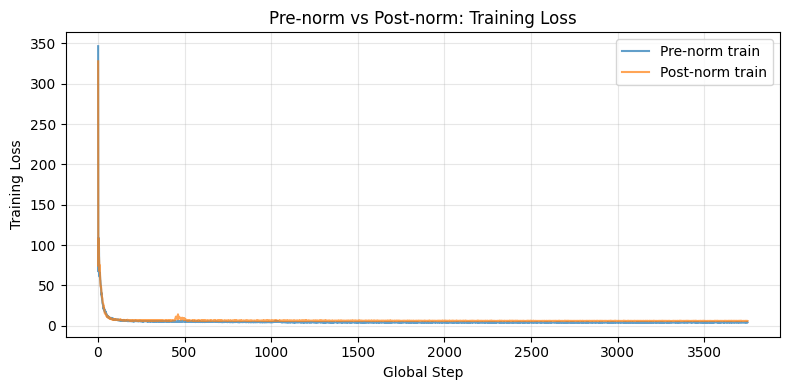

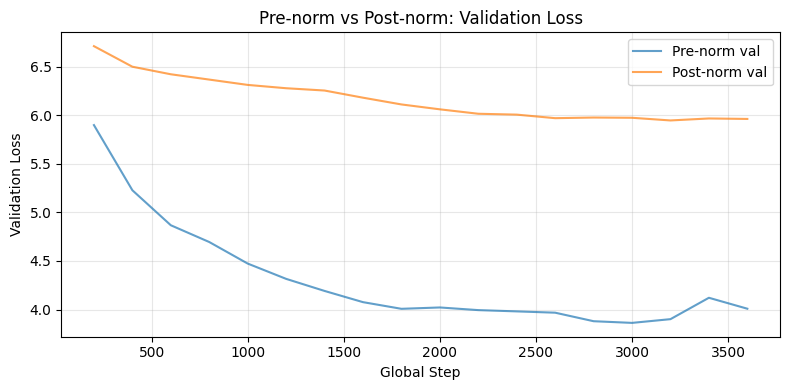

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Pre‑norm logs
pre_train_log = "training_logs/exp_pre_post_large/prenormtransformer_training_log.csv"
pre_val_log   = "training_logs/exp_pre_post_large/prenormtransformer_validation_log.csv"

# Post‑norm logs
post_train_log = "training_logs/exp_pre_post_large/postnormtransformer_training_log.csv"
post_val_log   = "training_logs/exp_pre_post_large/postnormtransformer_validation_log.csv"

def load_log(path):
    if not os.path.exists(path):
        print(f"Missing log: {path}")
        return None, None
    data = np.genfromtxt(path, delimiter=",", skip_header=1)
    return data[:, 4], data[:, 5]  # global_step, loss

pre_train_steps, pre_train_losses = load_log(pre_train_log)
pre_val_steps,   pre_val_losses   = load_log(pre_val_log)
post_train_steps, post_train_losses = load_log(post_train_log)
post_val_steps,   post_val_losses   = load_log(post_val_log)

# -------- Figure 1: Training loss only --------
plt.figure(figsize=(8, 4))
if pre_train_steps is not None:
    plt.plot(pre_train_steps, pre_train_losses, label="Pre‑norm train", alpha=0.7)
if post_train_steps is not None:
    plt.plot(post_train_steps, post_train_losses, label="Post‑norm train", alpha=0.7)

plt.xlabel("Global Step")
plt.ylabel("Training Loss")
plt.title("Pre‑norm vs Post‑norm: Training Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------- Figure 2: Validation loss only --------
plt.figure(figsize=(8, 4))
if pre_val_steps is not None:
    plt.plot(pre_val_steps, pre_val_losses, label="Pre‑norm val", alpha=0.7)
if post_val_steps is not None:
    plt.plot(post_val_steps, post_val_losses, label="Post‑norm val", alpha=0.7)

plt.xlabel("Global Step")
plt.ylabel("Validation Loss")
plt.title("Pre‑norm vs Post‑norm: Validation Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
def summarize(name, steps, losses):
    if steps is None:
        return
    print(
        f"{name}: first={losses[0]:.3f}, last={losses[-1]:.3f}, "
        f"drop={(losses[0]-losses[-1])/losses[0]*100:.1f}%"
    )

summarize("Pre‑norm train", pre_train_steps, pre_train_losses)
summarize("Pre‑norm val",   pre_val_steps,   pre_val_losses)
summarize("Post‑norm train", post_train_steps, post_train_losses)
summarize("Post‑norm val",   post_val_steps,   post_val_losses)

Pre‑norm train: first=346.666, last=4.134, drop=98.8%
Pre‑norm val: first=5.899, last=4.009, drop=32.0%
Post‑norm train: first=327.865, last=5.924, drop=98.2%
Post‑norm val: first=6.712, last=5.963, drop=11.2%


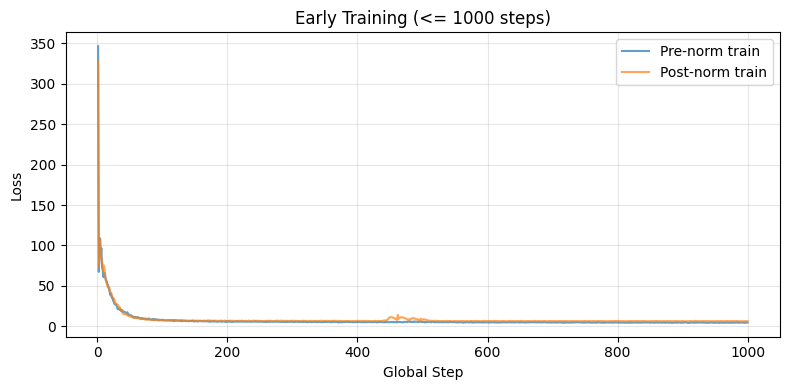

In [39]:
max_step_view = 1000  # adjust as you like

plt.figure(figsize=(8, 4))

if pre_train_steps is not None:
    mask = pre_train_steps <= max_step_view
    plt.plot(pre_train_steps[mask], pre_train_losses[mask], label="Pre‑norm train", alpha=0.7)
if post_train_steps is not None:
    mask = post_train_steps <= max_step_view
    plt.plot(post_train_steps[mask], post_train_losses[mask], label="Post‑norm train", alpha=0.7)

plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.title(f"Early Training (<= {max_step_view} steps)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

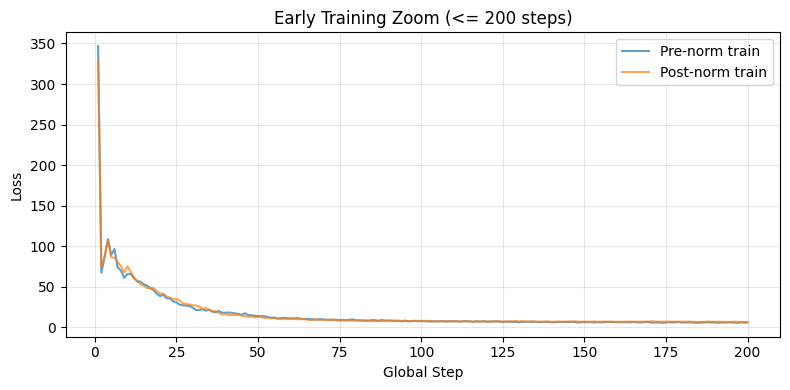

In [40]:
max_step_view = 200  # zoom into the very early training phase

plt.figure(figsize=(8, 4))

if pre_train_steps is not None:
    mask = pre_train_steps <= max_step_view
    plt.plot(pre_train_steps[mask], pre_train_losses[mask], label="Pre‑norm train", alpha=0.7)
if post_train_steps is not None:
    mask = post_train_steps <= max_step_view
    plt.plot(post_train_steps[mask], post_train_losses[mask], label="Post‑norm train", alpha=0.7)

plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.title(f"Early Training Zoom (<= {max_step_view} steps)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()